In [183]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from pandas.tseries.holiday import USFederalHolidayCalendar

In [165]:
counts = pd.read_csv('fremont_hourly.csv', index_col='Date', parse_dates=True)

In [167]:
counts = counts.loc['2012':'2016']

<ipython-input-167-b83ea7ce2257>:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  counts = counts.loc['2012':'2016']


In [168]:
weather = pd.read_csv('599021.csv', index_col='DATE', parse_dates=True)

In [169]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]

In [25]:
# counts.groupby(counts.index.date).sum().sum(axis=1)

In [170]:
days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [171]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012','2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [172]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m ,0, 2))) / 180.

In [173]:
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))

<ipython-input-172-a0e1ec592c66>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000, 12, 21)).days


<AxesSubplot:xlabel='Date'>

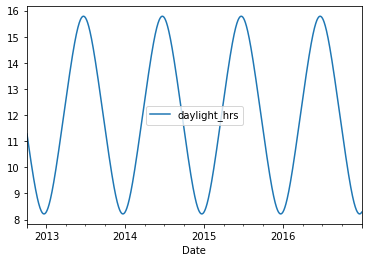

In [174]:
daily[['daylight_hrs']].plot()

In [175]:
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [176]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [177]:
column_names = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun','holiday','daylight_hrs','PRCP','dry day','Temp (C)','annual']
X = daily[column_names]
y = daily['Total']

In [179]:
# daily.isnull().sum()

In [180]:
model = LinearRegression(fit_intercept=False).fit(X, y)
daily['predicted'] = model.predict(X)

<AxesSubplot:xlabel='Date'>

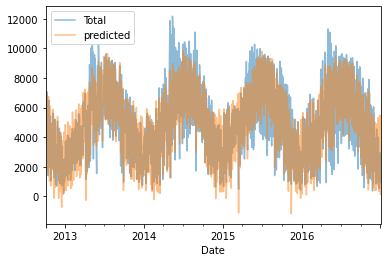

In [181]:
daily[['Total', 'predicted']].plot(alpha=0.5)

In [182]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              1249.034560
Tue              1548.910255
Wed              1527.434105
Thu              1225.709259
Fri               550.395000
Sat             -2067.453491
Sun             -2172.728055
holiday         -2290.980080
daylight_hrs      232.211299
PRCP           -13328.291284
dry day          1027.674118
Temp (C)         1407.321371
annual             47.500255
dtype: float64

In [184]:
np.random.seed(1)
err = np.std([model.fit(*resample(X,y)).coef_ for i in range(1000)], 0)

In [185]:
pd.DataFrame({'effects':params.round(0),'error':err.round(0)})

,effects,error
Mon,1249.0,153.0
Tue,1549.0,154.0
Wed,1527.0,157.0
Thu,1226.0,156.0
Fri,550.0,147.0
Sat,-2067.0,147.0
Sun,-2173.0,151.0
holiday,-2291.0,293.0
daylight_hrs,232.0,16.0
PRCP,-13328.0,1046.0
